# 3. Fashion MNIST without ResNet

# Label Glossary
I know, I know, having this here is probably bad form!

| Label	| Description |
|:-----:|-------------|
|0	    | T-shirt/top |
|1	    | Trouser     |
|2	    | Pullover    | 
|3	    | Dress       |
|4	    | Coat        |
|5	    | Sandal      |
|6	    | Shirt       |
|7	    | Sneaker     |
|8	    | Bag         |
|9	    | Ankle boot  |

In [1]:
#import boilerplate
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
from fastai.vision.all import *

In [ ]:
#there is no verification that the files aren't already downloaded
import wget

train_images_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz"
train_labels_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz"
test_images_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz"
test_labels_url = "http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz"

wget.download(train_images_url, 'fashion/')
wget.download(train_labels_url, 'fashion/')
wget.download(test_images_url, 'fashion/')
wget.download(test_labels_url, 'fashion/')

In [3]:
#github.com/zalandoresearch/ inspired this, home of mnist fashion

#unpack images and labels

import gzip

with gzip.open('fashion/train-labels-idx1-ubyte.gz', 'rb') as lbpath:
    train_labels_np = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

with gzip.open('fashion/train-images-idx3-ubyte.gz', 'rb') as imgpath:
    train_images_np = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(train_labels_np), 784)

with gzip.open('fashion/t10k-labels-idx1-ubyte.gz', 'rb') as lbpath:
    test_labels_np = np.frombuffer(lbpath.read(), dtype=np.uint8, offset=8)

with gzip.open('fashion/t10k-images-idx3-ubyte.gz', 'rb') as imgpath:
    test_images_np = np.frombuffer(imgpath.read(), dtype=np.uint8, offset=16).reshape(len(test_labels_np), 784)

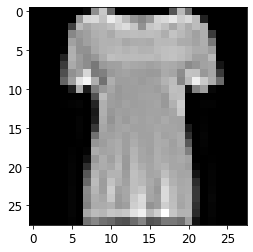

In [6]:
#take a look
plt.imshow((train_images_np[10].reshape(28,28)/255), cmap='gray')

In [8]:
#numpy array to pytorch tensor
train_labels = (torch.tensor(train_labels_np).cuda()).long().view(-1,1)
train_images = (torch.tensor(train_images_np).cuda()).float()/255

test_labels = (torch.tensor(test_labels_np).cuda()).long().view(-1,1)
test_images = (torch.tensor(test_images_np).cuda()).float()/255

train_images.shape,train_labels.shape

(torch.Size([60000, 784]), torch.Size([60000, 1]))

In [9]:
#zip into a training "dataset"
train_data = list(zip(train_images, train_labels))

#zip into a testing "dataset"
test_data = list(zip(test_images, test_labels))

In [136]:
train_dl = DataLoader(train_data, batch_size=256)
test_dl = DataLoader(test_data, batch_size=256)

In [137]:
#define loss function - use the CrossEntropyLoss function to calculate the loss from the predictions and actual values
def mnist_loss(pred, actual):
    loss = nn.CrossEntropyLoss()
    return loss(pred, actual.squeeze())

In [139]:
#calculate the gradient, by first calculating the predictions from the model, calculating the loss
def calc_grad(xb,yb,model):
    #get predictions from model
    pred = model(xb)
    #calculat loss from predictions and actual values
    loss = mnist_loss(pred, yb)
    #calculate the gradient
    loss.backward()
    return loss

In [140]:
#calculate batch accuracy
def batch_accuracy(pred, actual):
    #this took a sec to work out, get the maximum predicted category value, the index of that is the predicted digit
    digit_pred = pred.max(dim=1)[1]
    return (digit_pred == actual.squeeze()).float().mean()

In [141]:
# driver for one training epoch
def train_epoch(model, optimizer):
    batch_loss = []
    #iterate through image/label pairs in data set
    for xb, yb in train_dl:
        #get the prediction from the model, calc the loss, get the gradient
        batch_loss.append(calc_grad(xb, yb, model))
        #update the weights
        optimizer.step()
        #zero the gradients
        optimizer.zero_grad()
    return tensor(batch_loss).mean() 

In [142]:
class BasicOptim:
    #link class to model parameters and learning rate
    def __init__(self, params, lr): 
        self.params, self.lr = list(params), lr
    
    #update weights based on gradient and learning rate
    def step(self):
        for p in self.params:
            p.data -= p.grad.data * self.lr

    #reset gradient        
    def zero_grad(self):
        for p in self.params:
            p.grad = None

In [143]:
#basic network with 4 linear layers interspersed with 3 non-linearities
#accept a 28 * 28 size image and output 10 categories
simple_net = nn.Sequential(
    nn.Linear(28 * 28, 100),
    nn.ReLU(),
    nn.Linear(100, 100),
    nn.ReLU(),
    nn.Linear(100, 30),
    nn.ReLU(),
    nn.Linear(30, 10)
).cuda()

In [144]:
#starting accuracy = 0.1001
batch_accuracy(simple_net(test_images), test_labels)

tensor(0.1003, device='cuda:0')

In [145]:
opt = BasicOptim(simple_net.parameters(), lr=0.1)

In [146]:
def train_model(model, epochs, opt):
    for i in range(epochs):
        avg_batch_loss = train_epoch(model, opt)
        print(i, avg_batch_loss.item(), batch_accuracy(simple_net(test_images), test_labels).item())

In [147]:
%%time
train_model(simple_net, 10, opt)

0 1.422216534614563 0.6215999722480774
1 0.6996484994888306 0.7311999797821045
2 0.569175124168396 0.7809000015258789
3 0.5056050419807434 0.7983999848365784
4 0.4627949297428131 0.8137999773025513
5 0.43191346526145935 0.8222000002861023
6 0.40881070494651794 0.8305999636650085
7 0.3901730179786682 0.8313999772071838
8 0.3755873143672943 0.8375999927520752
9 0.3624356985092163 0.8446999788284302
Wall time: 3.91 s


In [148]:
#final accuracy = 0.8609
batch_accuracy(simple_net(test_images), test_labels)

tensor(0.8447, device='cuda:0')

In [42]:
epsilons = [0, .05, .1, .15, .2, .25, .3]

In [149]:
def attack_loss(pred, actual):
    loss = nn.CrossEntropyLoss()
    return loss(pred, actual)

In [43]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [96]:
attack_dl = DataLoader(train_data, batch_size=1)
simple_net.eval()

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): ReLU()
  (4): Linear(in_features=100, out_features=30, bias=True)
  (5): ReLU()
  (6): Linear(in_features=30, out_features=10, bias=True)
)

In [150]:
def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = attack_loss(output, target.view(1))
        
        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [151]:
accuracies = []
examples = []

# Run test for each epsilon
for eps in epsilons:
    acc, ex = test(simple_net, device, attack_dl, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 51751 / 60000 = 0.8625166666666667
Epsilon: 0.05	Test Accuracy = 26381 / 60000 = 0.4396833333333333
Epsilon: 0.1	Test Accuracy = 10062 / 60000 = 0.1677
Epsilon: 0.15	Test Accuracy = 3487 / 60000 = 0.058116666666666664
Epsilon: 0.2	Test Accuracy = 1039 / 60000 = 0.017316666666666668
Epsilon: 0.25	Test Accuracy = 282 / 60000 = 0.0047
Epsilon: 0.3	Test Accuracy = 56 / 60000 = 0.0009333333333333333


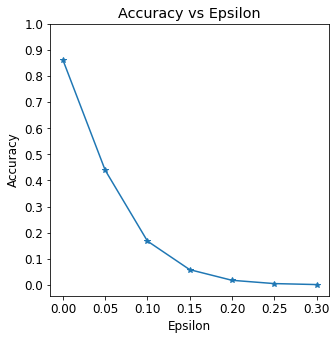

In [155]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

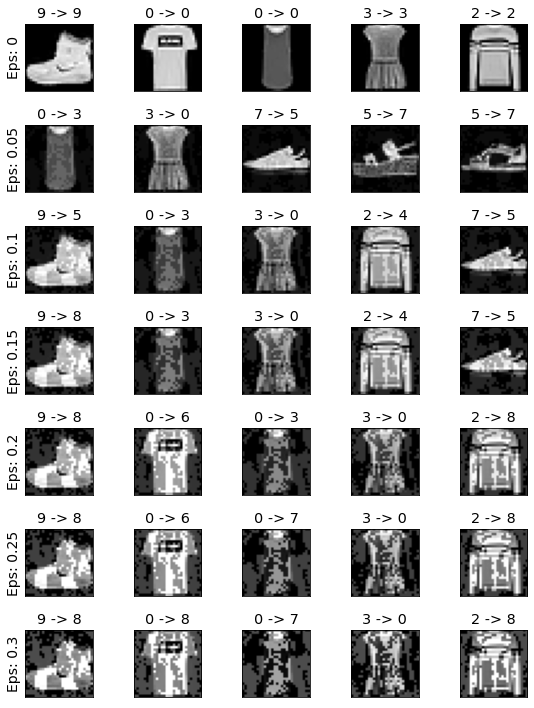

In [178]:
# Plot several examples of adversarial samples at each epsilon
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex.reshape((28,28)), cmap="gray")
plt.tight_layout()
plt.show()

# Q & A

**What dataset did you pick, and why?**

I chose to try on the Fashion MNIST dataset. I chose this dataset because I had it on my PC with a simple model all set up. 

**What model did you attack? Was this a pretrained model or did you train the model?**

I used the simple model that I trained for the Fashion MNIST dataset. I instantiated and trained the model separately for this exericsie, however.

**How successful was the final result? Success is not required for credit. How did you measure success?**

It was super efffective, it didn't take much noise to absolutely destroy the accuracy. At an epsilon of 0, the accuracy was 86%, at an epsilon value of just 0.05, the accuracy dropped to 44%.

I think because the model wasn't particularly robust, that the accuracy dropped so dramatically.
**What challenges did you face along the way and how did you overcome them?**

The biggest challenged was just working through the example code to understand the steps in order to be able to make the correct changes for my model to work. It wasn't too tough once I figured it out.
